In [1]:

import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pandas as pd
import seaborn as sns



In [13]:

speeds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]
weights = np.arange(0,200,10)
stim_type = 'smooth'
net_name = 'Reciporcal_fitted_mono_linear/'


# load responses 
response_data_RG = pd.read_csv(f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net_name}/responses_RG.csv')
response_data_RB = pd.read_csv(f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net_name}/responses_RB.csv')
# load gridsearch 
df = pd.read_csv(f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net_name}/anticipation_data.csv')

df.head(),df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       18 non-null     int64  
 1   wAB              18 non-null     float64
 2   wBA              18 non-null     float64
 3   speed            18 non-null     float64
 4   peak_RG          18 non-null     float64
 5   peak_RB          18 non-null     float64
 6   peak_drive       18 non-null     float64
 7   tp_rf_GC_mid     18 non-null     float64
 8   peak_RG_pooling  18 non-null     float64
 9   peak_RB_pooling  18 non-null     float64
 10  onset_shift      0 non-null      float64
 11  onset_shift_RB   18 non-null     float64
 12  onset_shift_RG   18 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 2.0 KB


(   Unnamed: 0   wAB   wBA  speed  peak_RG  peak_RB  peak_drive  tp_rf_GC_mid  \
 0           0  20.0  20.0    0.5    2.801    2.977       3.187      3.004992   
 1           1  10.0  20.0    0.5    2.788    3.032       3.187      3.004992   
 2           2   0.0  20.0    0.5    2.781    3.195       3.187      3.004992   
 3           3  20.0  10.0    0.5    2.788    3.032       3.187      3.004992   
 4           4  10.0  10.0    0.5    2.783    3.100       3.187      3.004992   
 
    peak_RG_pooling  peak_RB_pooling  onset_shift  onset_shift_RB  \
 0            2.781            3.195          NaN            19.0   
 1            2.781            3.195          NaN            18.0   
 2            2.781            3.195          NaN             0.0   
 3            2.781            3.195          NaN            18.0   
 4            2.781            3.195          NaN            13.0   
 
    onset_shift_RG  
 0            52.0  
 1            37.0  
 2             0.0  
 3          

In [14]:
# load V_drive
refdict={}
for si in speeds:
    fp = f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net_name}/wBA/wBA_0.0/smooth_{si}'

    with open(f'{fp}/out', 'rb') as handle:
        out = pickle.load(handle)
    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)

    dt = params['dt']

    refdict[f'{si}'] = {}
    refdict[f'{si}']['RG'] = out['RG']
    refdict[f'{si}']['RB'] = out['RB'][50,:]
    refdict[f'{si}']['drive'] = out['F']
    refdict[f'{si}']['max_tp_RG'] = np.argmax(out['RG'])*dt
    refdict[f'{si}']['max_tp_RB'] = np.argmax(out['RB'][50,:])*dt


In [18]:
speeds = df['speed'].unique()
weights = df['wBA'].unique()

In [15]:
# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

df['ant_RG_pool_time']  =  df['peak_RG_pooling'] - df['peak_RG'] 
df['ant_RG_pool_space'] = df['ant_RG_pool_time']* df['speed']


# calculate anticipation with respect to V_drive
df['ant_RB_drive_time']  =  df['peak_drive'] - df['peak_RB'] 
df['ant_RB_drive_space'] = df['ant_RB_drive_time']* df['speed']

df['ant_RB_pool_time']  =  df['peak_RB_pooling'] - df['peak_RB'] 
df['ant_RB_pool_space'] = df['ant_RB_pool_time']* df['speed']

In [16]:
# chose a condition to plot

dfgrouped = df.groupby(['wAB'])
g = dfgrouped.get_group(10)
ggrouped = g.groupby(['wBA'])



# RG responses and peak check

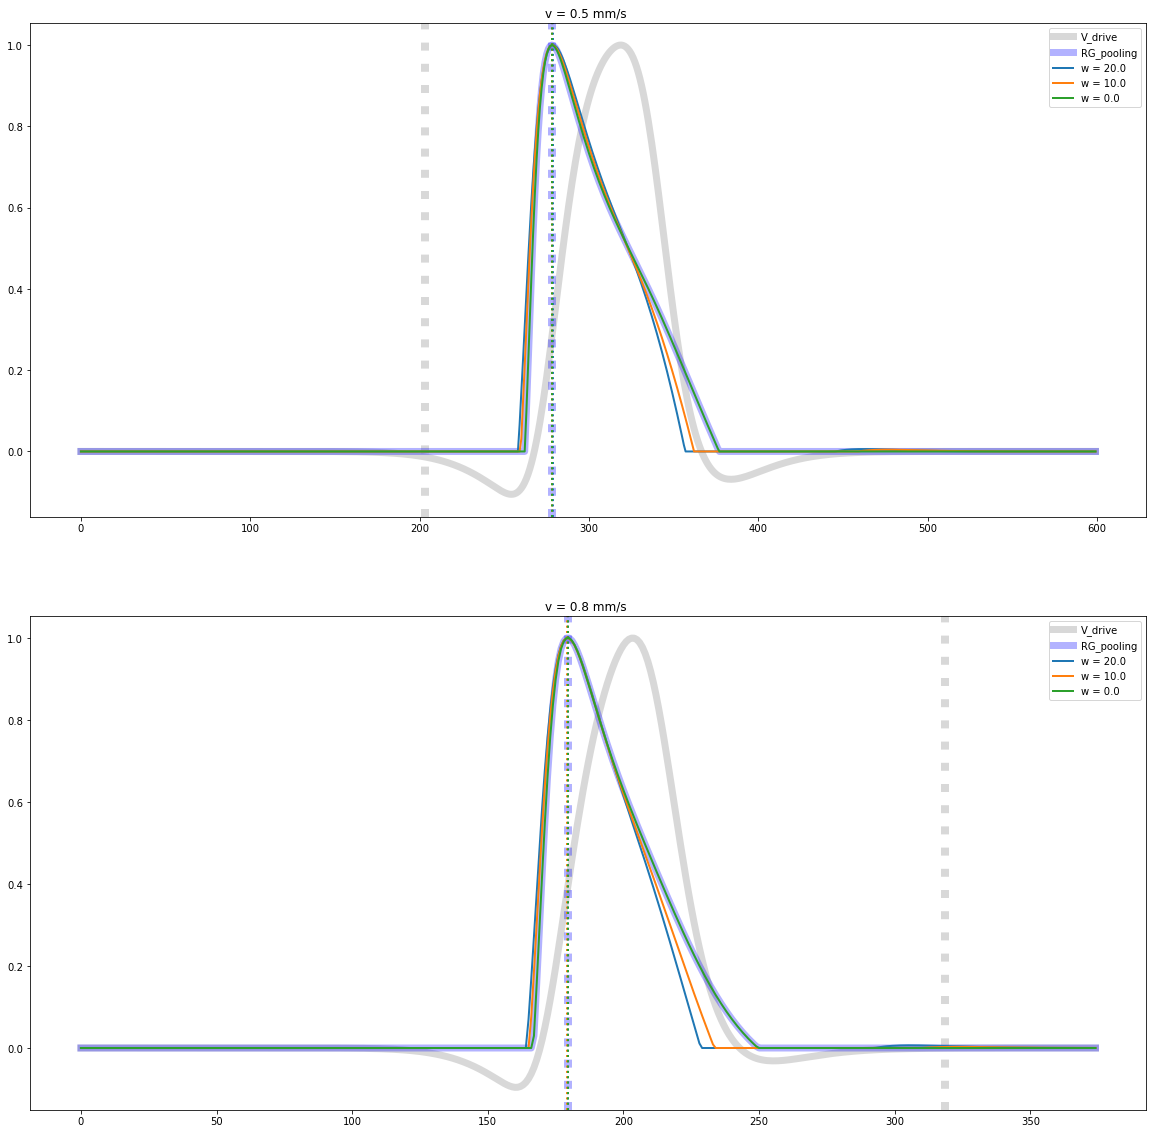

In [22]:
fig,ax = plt.subplots(len(speeds),1,figsize  = (20,20))

for i,si in enumerate(speeds):
    ax[i].plot(refdict[f'{si}']['drive'][0::10]/np.max(refdict[f'{si}']['drive'][0::10]), color = 'grey', linewidth = 7, alpha = 0.3, label = 'V_drive')
    ax[i].axvline(peak_drive/0.01, color = 'grey', alpha = 0.3,linewidth = 8, linestyle = ':')

    ax[i].plot(refdict[f'{si}']['RG'][0::10]/np.max(refdict[f'{si}']['RG'][0::10]), color = 'blue', linewidth = 7, alpha = 0.3, label = 'RG_pooling')
    ax[i].axvline(refdict[f'{si}']['max_tp_RG']/0.01, color = 'blue', alpha = 0.3,linewidth = 8, linestyle = ':')


    for x,wx in enumerate(weights):
        gwBA = ggrouped.get_group(wx)
        idx = gwBA.index[gwBA['speed'] == si].tolist()[0]
        RG = response_data_RG[f'{idx}']/ np.max(response_data_RG[f'{idx}'])
        peak_RG = gwBA['peak_RG'][idx]
        peak_drive = gwBA['peak_drive'][idx]
        #ax[i].plot(refdict[f'{si}']['resp'][0::10], color = 'grey', linewidth = 7, alpha = 0.3)
        obj = ax[i].plot(RG, label = f'w = {wx}', linewidth = 2)
        ax[i].axvline(peak_RG/0.01, color = obj[0].get_color(), linestyle = ':', linewidth =2)

        ax[i].legend()
        ax[i].set_title(f'v = {si} mm/s ')

        # ax[0].set_xlim(300,800)
        # ax[1].set_xlim(40,110)

# RB Responses and peak check

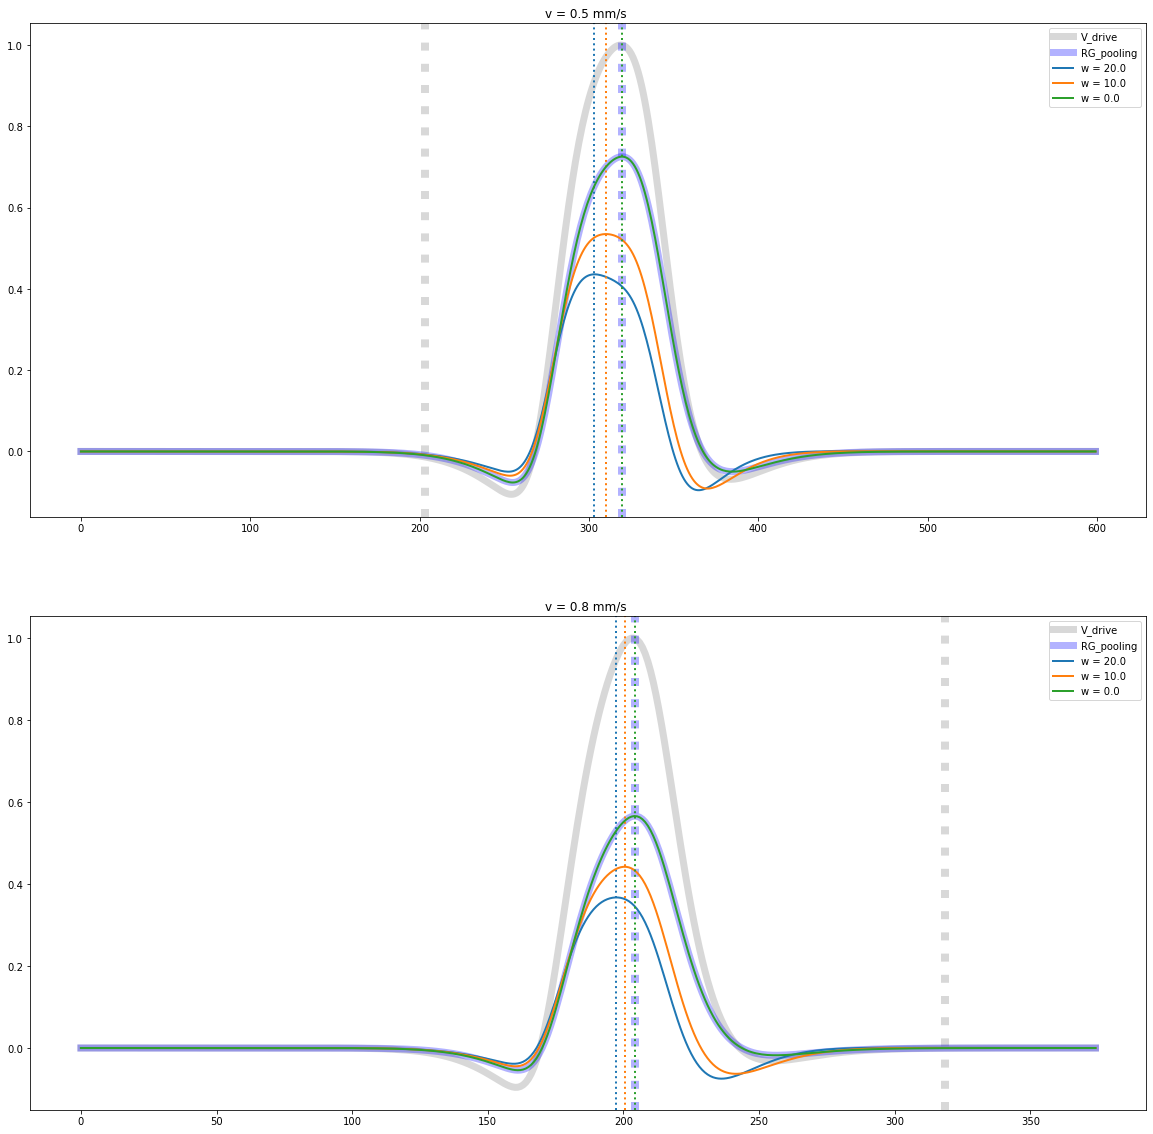

In [25]:
fig,ax = plt.subplots(len(speeds),1,figsize  = (20,20))

for i,si in enumerate(speeds):
    ax[i].plot(refdict[f'{si}']['drive'][0::10]/np.max(refdict[f'{si}']['drive'][0::10]), color = 'grey', linewidth = 7, alpha = 0.3, label = 'V_drive')
    ax[i].axvline(peak_drive/0.01, color = 'grey', alpha = 0.3,linewidth = 8, linestyle = ':')

    ax[i].plot(refdict[f'{si}']['RB'][0::10]/np.max(refdict[f'{si}']['RG'][0::10]), color = 'blue', linewidth = 7, alpha = 0.3, label = 'RG_pooling')
    ax[i].axvline(refdict[f'{si}']['max_tp_RB']/0.01, color = 'blue', alpha = 0.3,linewidth = 8, linestyle = ':')


    for x,wx in enumerate(weights):
        gwBA = ggrouped.get_group(wx)
        idx = gwBA.index[gwBA['speed'] == si].tolist()[0]
        RB = response_data_RB[f'{idx}']/ np.max(response_data_RG[f'{idx}'])
        peak_RB = gwBA['peak_RB'][idx]
        peak_drive = gwBA['peak_drive'][idx]
        #ax[i].plot(refdict[f'{si}']['resp'][0::10], color = 'grey', linewidth = 7, alpha = 0.3)
        obj = ax[i].plot(RB, label = f'w = {wx}', linewidth = 2)
        ax[i].axvline(peak_RB/0.01, color = obj[0].get_color(), linestyle = ':', linewidth =2)

        ax[i].legend()
        ax[i].set_title(f'v = {si} mm/s ')

        # ax[0].set_xlim(300,800)
        # ax[1].set_xlim(40,110)

# heatmap for one speed 

In [30]:
speeds

array([0.5, 0.8])

In [34]:
dfs = df.groupby('speed')
df08 = dfs.get_group(0.8)
var = 'ant_RG_drive_time'
var = 'onset_shift_RG'
dfs_heatmap = df08.pivot('wBA','wAB',var)


<AxesSubplot:xlabel='wAB', ylabel='wBA'>

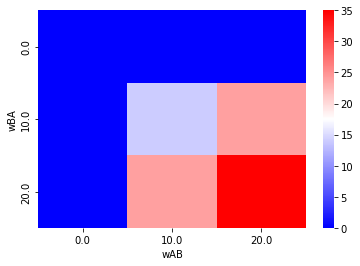

In [35]:
sns.heatmap(dfs_heatmap, cmap = 'bwr')


0.0
10.0
50.0


KeyError: 50.0

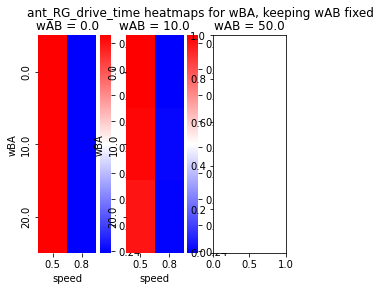

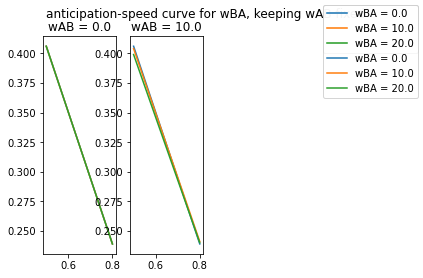

In [33]:
# multiple heatmaps, keeping w+ fixed and changing w-
dfgrouped = df.groupby(['wAB'])

var = 'ant_RG_drive_time'

fig = plt.figure()
fig.suptitle(f'{var} heatmaps for wBA, keeping wAB fixed')


fig2 = plt.figure()
fig2.suptitle('anticipation-speed curve for wBA, keeping wAB fixed')
weights = [0.0,10.0,50.0,100.0]
for i,w in enumerate(weights):
    print(w)
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'wAB = {w}')
    g = dfgrouped.get_group(w)
    # plot heatmap for beta
    g_heatmap = g.pivot('wBA','speed',var)
    sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')

    subg = g.groupby(['wBA'])
    ax = fig2.add_subplot(1,4,i+1)
    ax.set_title(f'wAB = {w}')
    for x,w2 in enumerate(subg.groups):
        sg = subg.get_group(w2)
        if i == 0:
            plt.plot(sg['speed'], sg[var], label = f'wBA = {w2}')
            #sg.plot( x = 'speed', y = 'ant_RG_drive_space', label =f'wBA = {w2}', ax = ax)
        else:
            plt.plot(sg['speed'], sg[var], label = f'wBA = {w2}')
            #sg.plot( x = 'speed', y = 'ant_RG_drive_space', ax = ax)

    fig2.legend()

